In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import DataSplitter
import utils
from sklearn.preprocessing import StandardScaler
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df60 = DataSplitter.getTrainData(60)

df60_line = df60[df60['line'] == '1A']
df60_line = df60_line.reset_index(drop=True)
#df60_line = df60_line.set_index(pd.RangeIndex(start=0, stop=df60_line.shape[0]))

train60, val60 = DataSplitter.performTrainValSplit(df60_line)
train60_line = train60.reset_index(drop=True)
val60_line = val60.reset_index(drop=True)

# Recursive

Docs https://skforecast.org/0.11.0/user_guides/autoregresive-forecaster.html

Example https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

SHAP https://skforecast.org/0.11.0/user_guides/explainability.html

In [107]:
target = 'passengersBoarding'
dropCols = ['date', 'hour', 'year', 'quarter', 'Q1', 'month', 'monthNumber', 'weekNumber', 'weekDay', 
            'dateNumber', 'mon', 'workdayPlan', 'line', 'passengersBoarding', 'eventName', 'diff', 'datetime',
            'diffLag1', 'diffLag2', 'diffLag3', 'diffLag4', 'diffLag5', 'diffLag6', 'diffLag7', 'diffLag8', 'diffLag9', 'diffLag10',
            'diffLag11', 'diffLag12', 'diffLag13', 'diffLag14', 'diffLag15', 'diffLag16', 'diffLag17', 'diffLag18', 'diffLag19', 'diffLag20',
            'diffLag40', 'diffLag60', 'diffLag80', 'diffLag100', 'diffLag120', 'diffLag140']

train_index = pd.RangeIndex(start=0, stop=train60_line.shape[0])
val_index = pd.RangeIndex(start=train60_line.shape[0], stop=train60_line.shape[0]+val60_line.shape[0])

X_train = train60_line.drop(columns=dropCols, axis=1)
y_train = train60_line[target]
X_val = val60_line.drop(columns=dropCols, axis=1)
y_val = val60_line[target]

X_train.index = train_index
y_train.index = train_index
X_val.index = val_index
y_val.index = val_index

In [108]:
model = xgb.XGBRegressor(n_estimators=35, max_depth=4, eta=0.05, seed=42)

scalar = StandardScaler()
exog_scalar = StandardScaler()
forecaster = ForecasterAutoreg(
                 regressor = model,
                 lags      = [1, 20, 120, 140],
                 differentiation=1,
                 transformer_y=scalar,
                 transformer_exog=exog_scalar
             )

forecaster.fit(y=y_train, exog=X_train)
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=35,
             n_jobs=None, num_parallel_tree=None, ...) 
Lags: [  1  20 120 140] 
Transformer for y: StandardScaler() 
Transformer for exog: StandardScaler() 
Window size: 141 
Weight function included: False 
Differentiation order: 1 
Exogenous included: True 
Type of exogenous variable: <cl

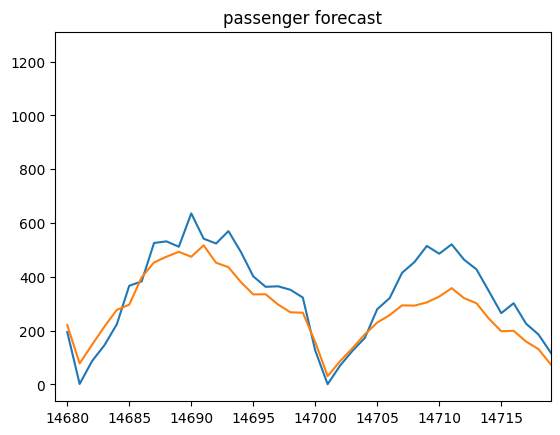

In [109]:
y_train_pred = forecaster.predict(steps=40, exog=X_val[:40])
y_train_pred
plt.plot(X_val.index, val60_line['passengersBoarding'])
plt.plot(X_val.index[:40], y_train_pred)
plt.xlim([14679, 14679+40])
plt.title('passenger forecast')
plt.show()

training MAE%: 0.15
training MAPE: 0.372
training RMSE%: 0.198


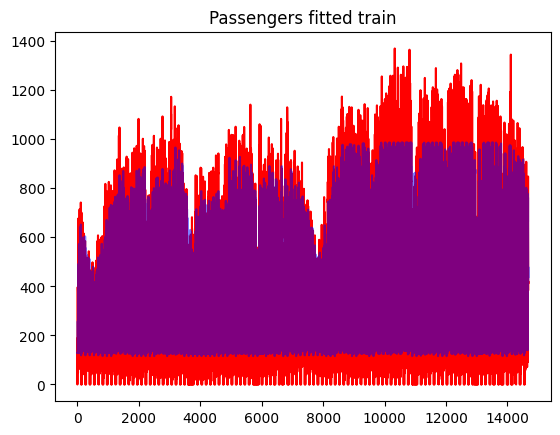

In [120]:
X_train['lag_1'] = y_train.shift(periods=1).fillna(0)
X_train['lag_20'] = y_train.shift(periods=20).fillna(0)
X_train['lag_120'] = y_train.shift(periods=120).fillna(0)
X_train['lag_140'] = y_train.shift(periods=140).fillna(0)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

print('training MAE%:', utils.MAE(y=y_train, yhat=y_train_pred))
print('training MAPE:', utils.MAPE(y=y_train, yhat=y_train_pred))
print('training RMSE%:', utils.RMSE(y=y_train, yhat=y_train_pred))

plt.plot(X_train.index, y_train, color='red')
plt.plot(X_train.index, y_train_pred, color='blue', alpha=0.5)
plt.title('Passengers fitted train')
plt.show()

In [ ]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_train)

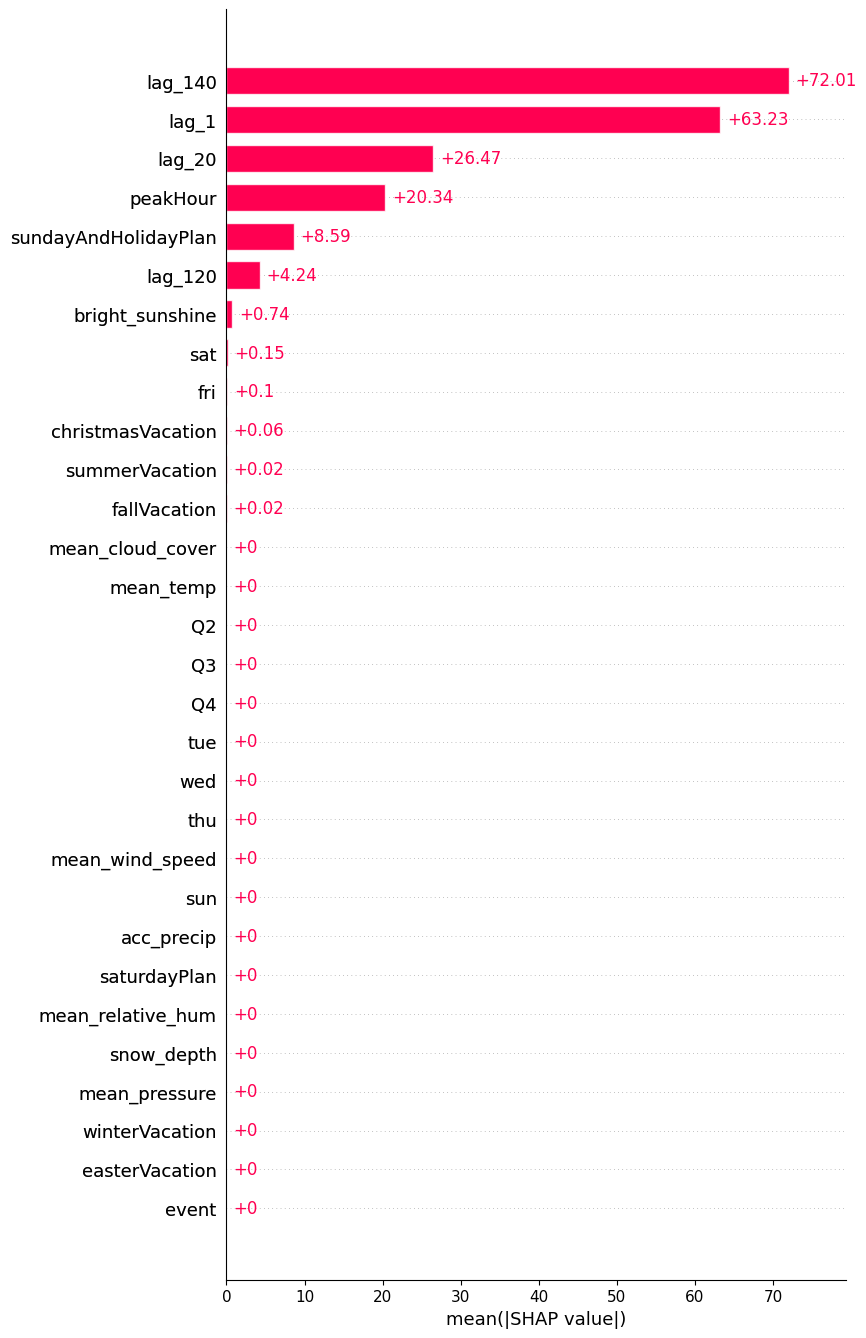

In [64]:
shap.plots.bar(shap_values, max_display=52)

# Direct

In [65]:
target = 'diff'
dropCols = ['date', 'hour', 'year', 'quarter', 'Q1', 'month', 'monthNumber', 'weekNumber', 'weekDay', 
            'dateNumber', 'mon', 'workdayPlan', 'line', 'passengersBoarding', 'eventName', 'diff', 'datetime']

X_train = train60_line.drop(columns=dropCols, axis=1)
y_train = train60_line[target]
X_val = val60_line.drop(columns=dropCols, axis=1)
y_val = val60_line[target]

# scale and keep column names
scalar = StandardScaler()
X_train_scaled = pd.DataFrame()
X_val_scaled = pd.DataFrame()
X_train_scaled[X_train.columns] = scalar.fit_transform(X_train[X_train.columns])
X_val_scaled[X_val.columns] = scalar.transform(X_val[X_val.columns])

In [66]:
# grid search for best val mae%
best_val_mae = 100000
best_model = None
for estimators in [2, 5, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    for depth in [2, 3, 4, 5, 7, 9]:
        for lr in [0.5, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01, 0.001]:
            model = xgb.XGBRegressor(n_estimators=estimators, max_depth=depth, eta=lr, seed=42)
            model.fit(X_train_scaled, y_train)

            y_train_pred = model.predict(X_train_scaled)
            y_val_pred = model.predict(X_val_scaled)
            
            # cumsum predictions to produce passengers
            period = 20
            y_train_pred_passengers = train60_line['passengersBoarding'].shift(periods=period).fillna(0) + pd.Series(y_train_pred).rolling(window=period).sum().fillna(0)
            #y_val_pred_passengers = val60_line['passengersBoarding'].shift(periods=period).fillna(0) + pd.Series(y_val_pred).rolling(window=period).sum().fillna(0)
            # experimental correction
            val60_line_extended = pd.concat([train60_line['passengersBoarding'].tail(period), val60_line['passengersBoarding']], ignore_index=True).shift(periods=period)[period:]
            y_val_pred_extended = pd.concat([train60_line['diff'].tail(period), pd.Series(y_val_pred)], ignore_index=True).rolling(window=period).sum()[period:]
            y_val_pred_passengers = val60_line_extended + y_val_pred_extended
            
            val_mae = utils.MAE(val60_line['passengersBoarding'], y_val_pred_passengers)
            val_mape = utils.MAPE(val60_line['passengersBoarding'], y_val_pred_passengers)
            val_rmse = utils.RMSE(val60_line['passengersBoarding'], y_val_pred_passengers)
            if val_mae < best_val_mae:
                best_val_mae = val_mae
                best_model = model
                print(estimators, depth, lr, val_mae, val_mape, val_rmse)

best_model.feature_names = list(X_train.columns)

2 2 0.5 0.263 nan 0.337
2 2 0.3 0.212 nan 0.294
2 2 0.25 0.2 nan 0.29
2 2 0.2 0.193 nan 0.291
2 2 0.15 0.19 nan 0.296
2 3 0.15 0.188 nan 0.284
2 4 0.15 0.187 nan 0.283
2 7 0.25 0.185 nan 0.261
2 7 0.2 0.184 nan 0.268
5 3 0.1 0.18 nan 0.266
5 4 0.3 0.179 nan 0.245
5 4 0.25 0.176 nan 0.24
5 5 0.2 0.175 nan 0.24
8 4 0.2 0.173 nan 0.233
8 4 0.1 0.171 nan 0.244
10 4 0.1 0.169 nan 0.237
15 5 0.1 0.167 nan 0.227
20 3 0.1 0.166 nan 0.227
25 4 0.05 0.165 nan 0.231
35 4 0.05 0.164 nan 0.225


In [67]:
# fit best model
y_train_pred = best_model.predict(X_train_scaled)
y_val_pred = best_model.predict(X_val_scaled)

# transform from diff to passengers by 1 step past
#y_train_pred_passengers = train60_line['passengersBoarding'].shift(periods=1).fillna(0) + y_train_pred
#y_val_pred_passengers = val60_line['passengersBoarding'].shift(periods=1).fillna(0) + y_val_pred

# by previous 40 step cumsum
period = 40
y_train_pred_passengers = train60_line['passengersBoarding'].shift(periods=period).fillna(0) + pd.Series(y_train_pred).rolling(window=period).sum().fillna(0)
#y_val_pred_passengers = val60_line['passengersBoarding'].shift(periods=period).fillna(0) + pd.Series(y_val_pred).rolling(window=period).sum().fillna(0)

# correction for first 40 obs
val60_line_extended = pd.concat([train60_line['passengersBoarding'].tail(period), val60_line['passengersBoarding']], ignore_index=True).shift(periods=period)[period:]
y_val_pred_extended = pd.concat([train60_line['diff'].tail(period), pd.Series(y_val_pred)], ignore_index=True).rolling(window=period).sum()[period:]
y_val_pred_passengers = val60_line_extended + y_val_pred_extended

print('training MAE%', utils.MAE(train60_line['passengersBoarding'], y_train_pred_passengers), 'validation MAE%', utils.MAE(val60_line['passengersBoarding'], y_val_pred_passengers))
print('training MAPE', utils.MAPE(train60_line['passengersBoarding'], y_train_pred_passengers), 'validation MAPE', utils.MAPE(val60_line['passengersBoarding'], y_val_pred_passengers))
print('training RMSE%', utils.RMSE(train60_line['passengersBoarding'], y_train_pred_passengers), 'validation RMSE%', utils.RMSE(val60_line['passengersBoarding'], y_val_pred_passengers))

training MAE% 0.265 validation MAE% 0.196
training MAPE 0.504 validation MAPE nan
training RMSE% 0.35 validation RMSE% 0.265


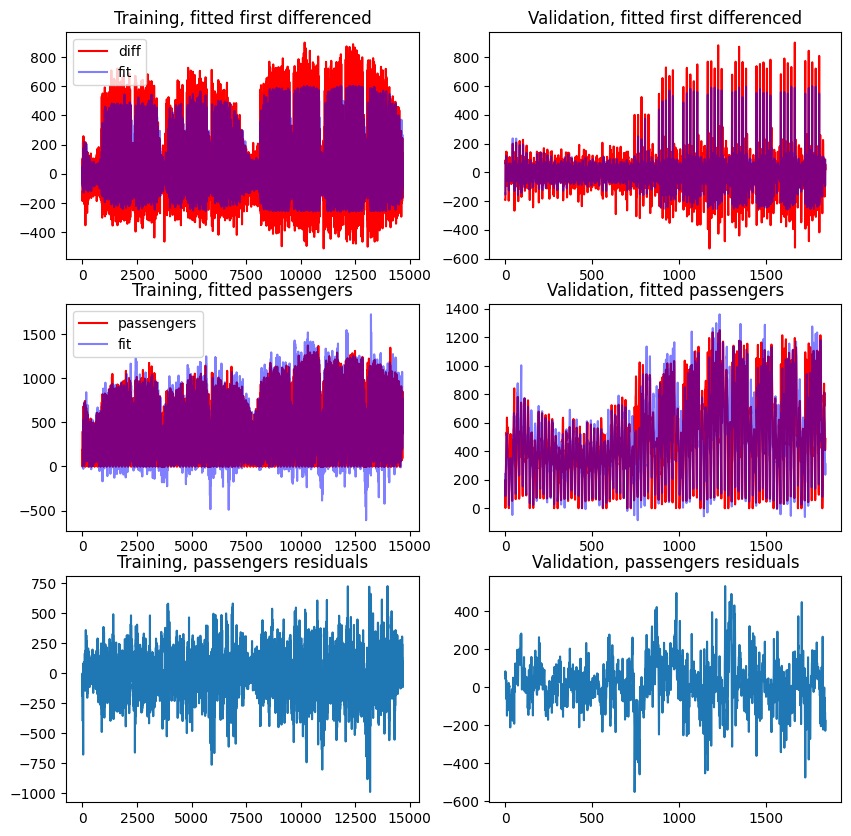

In [68]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

ax[0, 0].plot(y_train.index, y_train.values, color='red', label='diff')
ax[0, 0].plot(y_train.index, y_train_pred, color='blue', alpha=0.5, label='fit')
ax[0, 0].set_title('Training, fitted first differenced')
ax[0, 0].legend()

ax[1, 0].plot(X_train.index, train60_line['passengersBoarding'], color='red', label='passengers')
ax[1, 0].plot(X_train.index, y_train_pred_passengers, color='blue', alpha=0.5, label='fit')
ax[1, 0].set_title('Training, fitted passengers')
ax[1, 0].legend()

ax[2, 0].plot(X_train.index, y_train_pred_passengers - train60_line['passengersBoarding'].values)
ax[2, 0].set_title('Training, passengers residuals')

ax[0, 1].plot(y_val.index, y_val.values, color='red')
ax[0, 1].plot(y_val.index, y_val_pred, color='blue', alpha=0.5)
ax[0, 1].set_title('Validation, fitted first differenced')

ax[1, 1].plot(X_val.index, val60_line['passengersBoarding'], color='red')
ax[1, 1].plot(X_val.index, y_val_pred_passengers, color='blue', alpha=0.5)
ax[1, 1].set_title('Validation, fitted passengers')

ax[2, 1].plot(X_val.index, y_val_pred_passengers - val60_line['passengersBoarding'].values)
ax[2, 1].set_title('Validation, passengers residuals')

plt.show()

['peakHour', 'Q2', 'Q3', 'Q4', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'saturdayPlan', 'sundayAndHolidayPlan', 'summerVacation', 'fallVacation', 'christmasVacation', 'winterVacation', 'easterVacation', 'acc_precip', 'bright_sunshine', 'mean_cloud_cover', 'mean_pressure', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed', 'snow_depth', 'event', 'diffLag1', 'diffLag2', 'diffLag3', 'diffLag4', 'diffLag5', 'diffLag6', 'diffLag7', 'diffLag8', 'diffLag9', 'diffLag10', 'diffLag11', 'diffLag12', 'diffLag13', 'diffLag14', 'diffLag15', 'diffLag16', 'diffLag17', 'diffLag18', 'diffLag19', 'diffLag20', 'diffLag40', 'diffLag60', 'diffLag80', 'diffLag100', 'diffLag120', 'diffLag140']


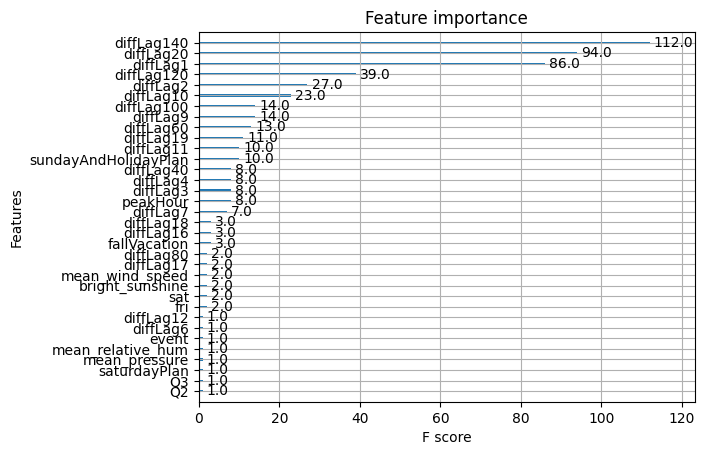

<Axes: title={'center': 'gain'}>

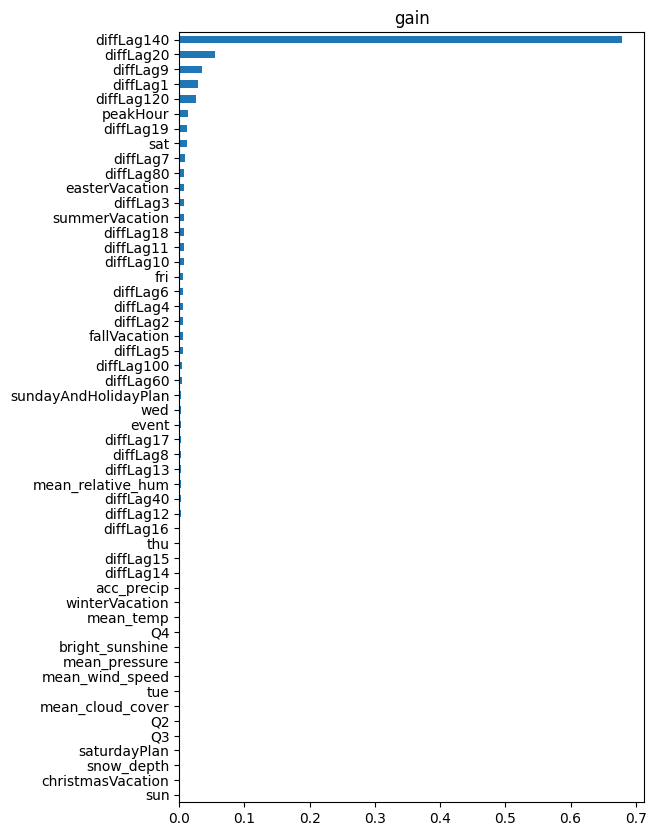

In [69]:
# feature importance
print(best_model.feature_names)

fig, ax = plt.subplots(1)
xgb.plot_importance(best_model, ax=ax)
plt.show()

importances = model.feature_importances_
pd.Series(importances, index=X_train.columns).sort_values().plot.barh(figsize=(6, 10), title='gain')

In [70]:
explainer = shap.Explainer(best_model.predict, X_train_scaled)
shap_values = explainer(X_train_scaled)

PermutationExplainer explainer: 14681it [03:58, 58.89it/s]                           


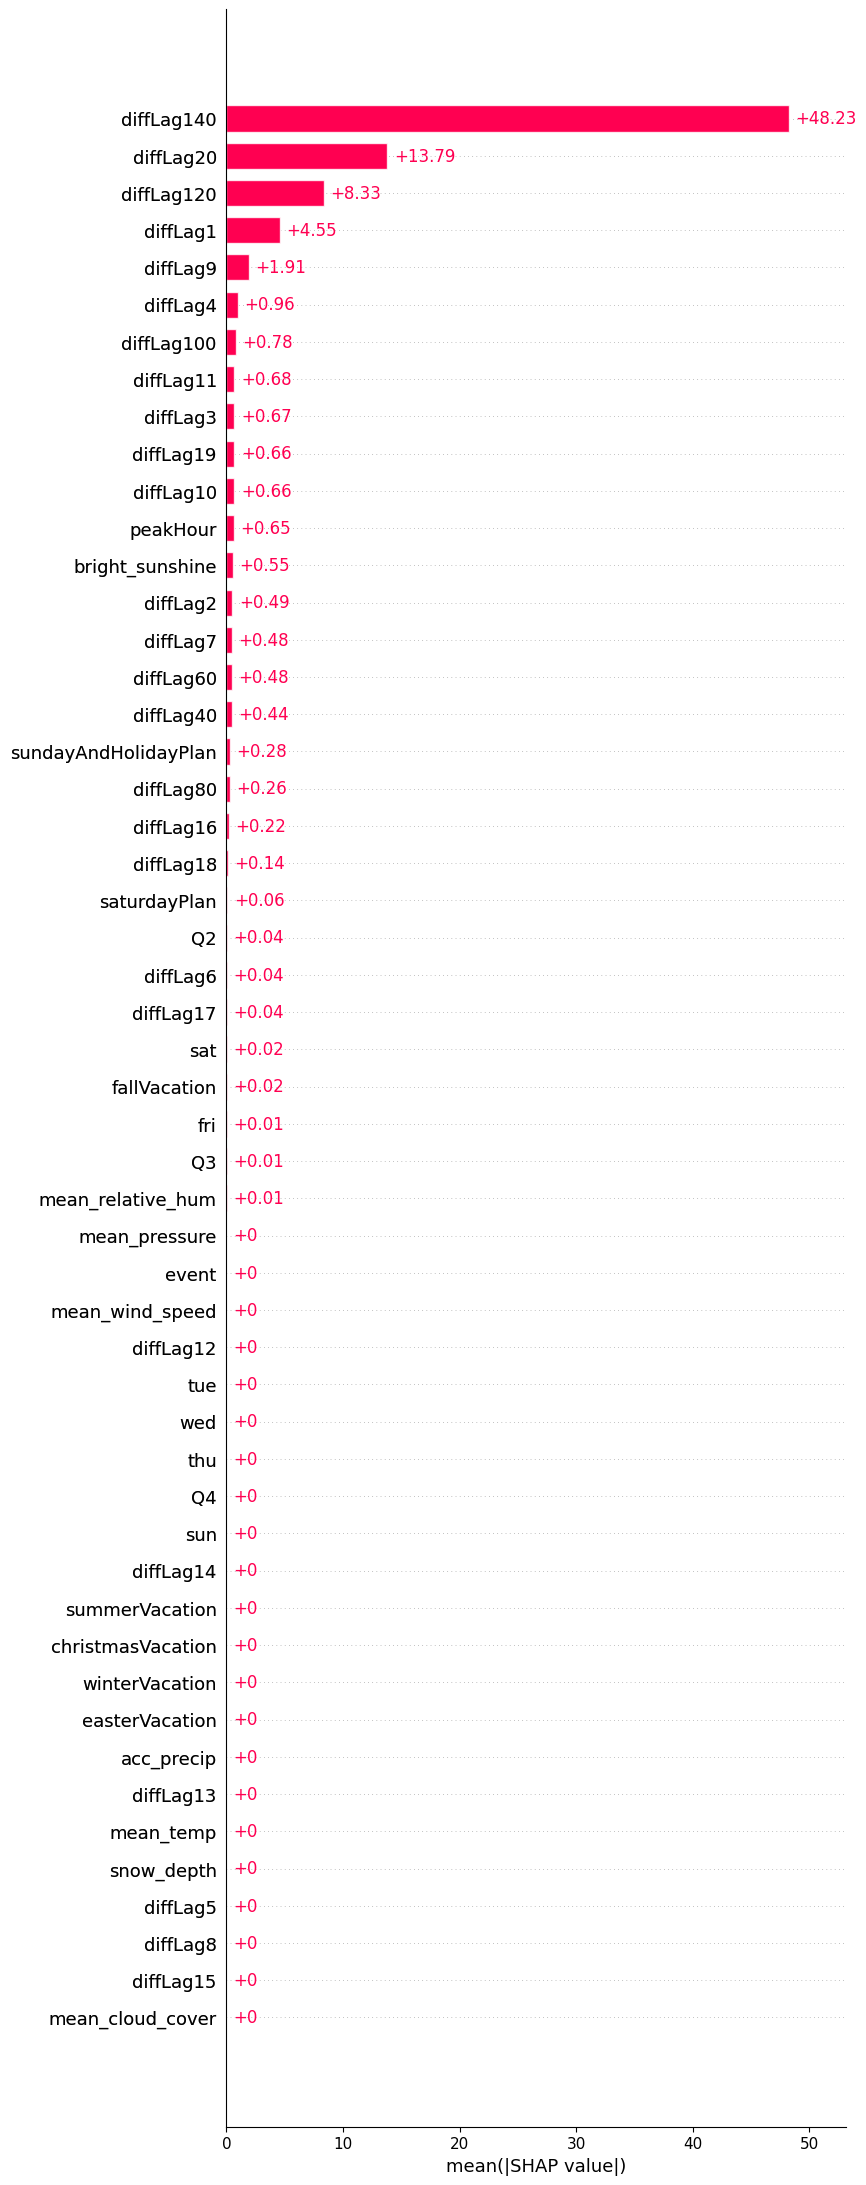

In [72]:
shap.plots.bar(shap_values, max_display=52)

# Recursive with fixed, expanding, rolling window

In [193]:
target = 'passengersBoarding'
dropCols = ['date', 'hour', 'year', 'quarter', 'Q1', 'month', 'monthNumber', 'weekNumber', 'weekDay', 
            'dateNumber', 'mon', 'workdayPlan', 'line', 'passengersBoarding', 'eventName', 'diff', 'datetime',
            'diffLag1', 'diffLag2', 'diffLag3', 'diffLag4', 'diffLag5', 'diffLag6', 'diffLag7', 'diffLag8', 'diffLag9', 'diffLag10',
            'diffLag11', 'diffLag12', 'diffLag13', 'diffLag14', 'diffLag15', 'diffLag16', 'diffLag17', 'diffLag18', 'diffLag19', 'diffLag20',
            'diffLag40', 'diffLag60', 'diffLag80', 'diffLag100', 'diffLag120', 'diffLag140']

train_index = pd.RangeIndex(start=0, stop=train60_line.shape[0])
val_index = pd.RangeIndex(start=train60_line.shape[0], stop=train60_line.shape[0]+val60_line.shape[0])

X_train = train60_line.drop(columns=dropCols, axis=1)
y_train = train60_line[target]
X_val = val60_line.drop(columns=dropCols, axis=1)
y_val = val60_line[target]

X_train.index = train_index
y_train.index = train_index
X_val.index = val_index
y_val.index = val_index

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
#elif torch.backends.mps.is_available():
#    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cpu


The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.


Execution time: 0.290 sec
val MAE%: 0.326
val MAPE: 0.771
val RMSE%: 0.453


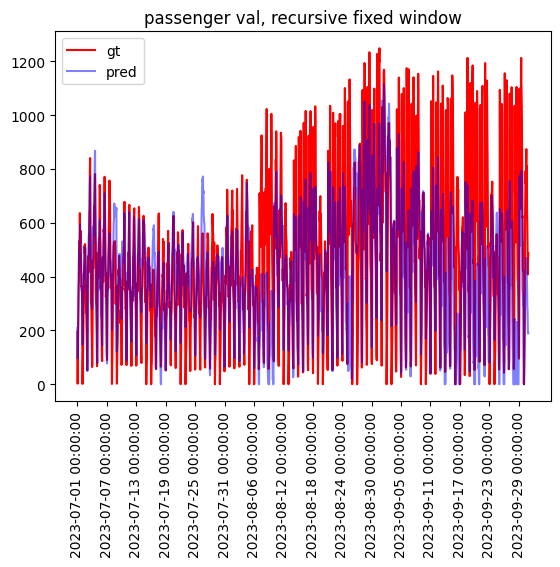

In [238]:
# fixed window forecast (no reestimation)
model = xgb.XGBRegressor(n_estimators=35, max_depth=40, eta=0.05, seed=42, device=device)

scalar = StandardScaler()
exog_scalar = StandardScaler()
forecaster = ForecasterAutoreg(
                 regressor = model,
                 lags      = [1, 20, 120, 140],
                 differentiation=1,
                 transformer_y=scalar,
                 transformer_exog=exog_scalar
             )

forecaster.fit(y=y_train, exog=X_train)

horizon = 40
y_val_pred = pd.Series()
indexrange = range(y_val.index[0], y_val.index[-1] + 1, horizon)

timer = utils.Time()
timer.start()
for idx, time in enumerate(indexrange):
    # include 141 last obs in train because of lags
    last_window = y_train.tail(forecaster.max_lag + 1)
    # include validation obs from first index to step before forecast
    if idx > 0:
        last_window = pd.concat([last_window, y_val.loc[:time-1]])
    
    # forecast starting from last window
    preds = forecaster.predict(steps=horizon, exog=X_val.loc[time:time+horizon], last_window=last_window)
    y_val_pred = pd.concat([y_val_pred, preds])
print(timer.end())

# round and cut off
y_val_pred = y_val_pred.round()
y_val_pred[y_val_pred < 0] = 0

print('val MAE%:', utils.MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', utils.MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', utils.RMSE(y=y_val, yhat=y_val_pred))
#############################################################################
# Mangler training loss
#############################################################################

plt.plot(X_val.index, val60_line['passengersBoarding'], color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive fixed window')
plt.legend()
plt.show()

RangeIndex(start=0, stop=14680, step=1)


The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.


RangeIndex(start=0, stop=14720, step=1)
RangeIndex(start=0, stop=14760, step=1)
RangeIndex(start=0, stop=14800, step=1)
RangeIndex(start=0, stop=14840, step=1)
RangeIndex(start=0, stop=14880, step=1)
RangeIndex(start=0, stop=14920, step=1)
RangeIndex(start=0, stop=14960, step=1)
RangeIndex(start=0, stop=15000, step=1)
RangeIndex(start=0, stop=15040, step=1)
RangeIndex(start=0, stop=15080, step=1)
RangeIndex(start=0, stop=15120, step=1)
RangeIndex(start=0, stop=15160, step=1)
RangeIndex(start=0, stop=15200, step=1)
RangeIndex(start=0, stop=15240, step=1)
RangeIndex(start=0, stop=15280, step=1)
RangeIndex(start=0, stop=15320, step=1)
RangeIndex(start=0, stop=15360, step=1)
RangeIndex(start=0, stop=15400, step=1)
RangeIndex(start=0, stop=15440, step=1)
RangeIndex(start=0, stop=15480, step=1)
RangeIndex(start=0, stop=15520, step=1)
RangeIndex(start=0, stop=15560, step=1)
RangeIndex(start=0, stop=15600, step=1)
RangeIndex(start=0, stop=15640, step=1)
RangeIndex(start=0, stop=15680, step=1)


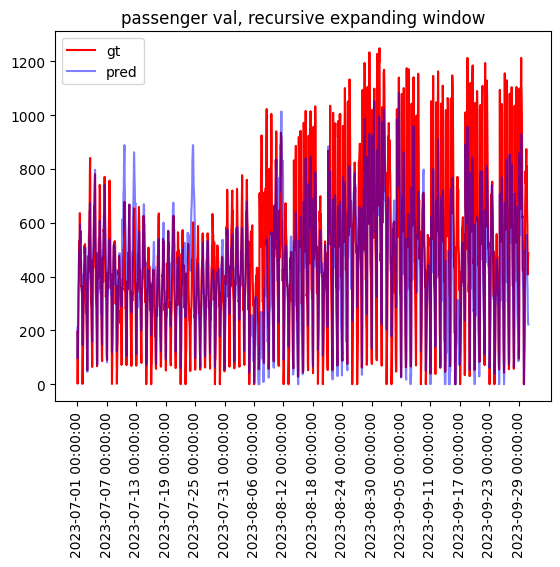

In [185]:
# expanding window forecast (reestimation)
model = xgb.XGBRegressor(n_estimators=35, max_depth=40, eta=0.05, seed=42)

scalar = StandardScaler()
exog_scalar = StandardScaler()
forecaster = ForecasterAutoreg(
                 regressor = model,
                 lags      = [1, 20, 120, 140],
                 differentiation=1,
                 transformer_y=scalar,
                 transformer_exog=exog_scalar
             )

horizon = 40
y_val_pred = pd.Series()
indexrange = range(y_val.index[0], y_val.index[-1] + 1, horizon)

# define training data
X_expanding = X_train
y_expanding = y_train

timer = utils.Time()
timer.start()
for idx, time in enumerate(indexrange):
    # include expanding window of previous validation data
    if idx > 0:
        y_expanding = pd.concat([y_expanding, y_val.loc[time-horizon:time-1]], ignore_index=True)
        X_expanding = pd.concat([X_expanding, X_val.loc[time-horizon:time-1]], ignore_index=True)
    
    print(y_expanding.index)

    forecaster.fit(y=y_expanding, exog=X_expanding)

    # forecast future validation data
    preds = forecaster.predict(steps=horizon, exog=X_val.loc[time:time+horizon])
    y_val_pred = pd.concat([y_val_pred, preds])
print(timer.end())

# round and cut off
y_val_pred = y_val_pred.round()
y_val_pred[y_val_pred < 0] = 0

print('MAE%:', utils.MAE(y=y_val, yhat=y_val_pred))
print('MAPE:', utils.MAPE(y=y_val, yhat=y_val_pred))
print('RMSE%:', utils.RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, val60_line['passengersBoarding'], color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive expanding window')
plt.legend()
plt.show()

RangeIndex(start=7400, stop=14680, step=1)


The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.


RangeIndex(start=7440, stop=14720, step=1)
RangeIndex(start=7480, stop=14760, step=1)
RangeIndex(start=7520, stop=14800, step=1)
RangeIndex(start=7560, stop=14840, step=1)
RangeIndex(start=7600, stop=14880, step=1)
RangeIndex(start=7640, stop=14920, step=1)
RangeIndex(start=7680, stop=14960, step=1)
RangeIndex(start=7720, stop=15000, step=1)
RangeIndex(start=7760, stop=15040, step=1)
RangeIndex(start=7800, stop=15080, step=1)
RangeIndex(start=7840, stop=15120, step=1)
RangeIndex(start=7880, stop=15160, step=1)
RangeIndex(start=7920, stop=15200, step=1)
RangeIndex(start=7960, stop=15240, step=1)
RangeIndex(start=8000, stop=15280, step=1)
RangeIndex(start=8040, stop=15320, step=1)
RangeIndex(start=8080, stop=15360, step=1)
RangeIndex(start=8120, stop=15400, step=1)
RangeIndex(start=8160, stop=15440, step=1)
RangeIndex(start=8200, stop=15480, step=1)
RangeIndex(start=8240, stop=15520, step=1)
RangeIndex(start=8280, stop=15560, step=1)
RangeIndex(start=8320, stop=15600, step=1)
RangeIndex(

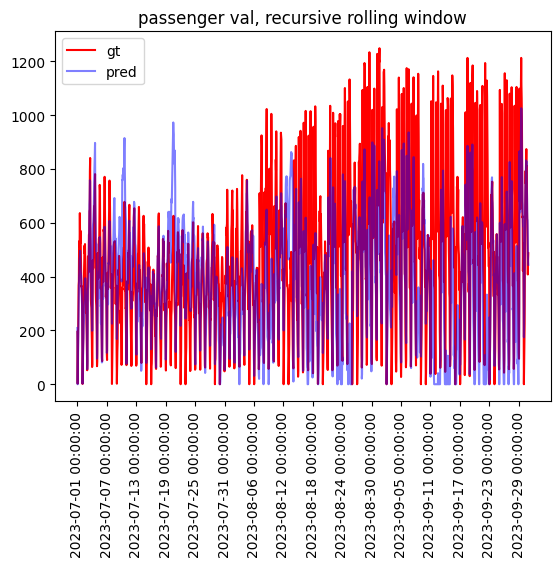

In [188]:
# sliding window forecast (reestimation)
model = xgb.XGBRegressor(n_estimators=35, max_depth=40, eta=0.05, seed=42)

scalar = StandardScaler()
exog_scalar = StandardScaler()
forecaster = ForecasterAutoreg(
                 regressor = model,
                 lags      = [1, 20, 120, 140],
                 differentiation=1,
                 transformer_y=scalar,
                 transformer_exog=exog_scalar
             )

horizon = 40
window_size = 20*7*52
y_val_pred = pd.Series()
indexrange = range(y_val.index[0], y_val.index[-1] + 1, horizon)

# define training data
X_sliding = pd.concat([X_train, X_val])
y_sliding = pd.concat([y_train, y_val])

timer = utils.Time()
timer.start()
for idx, time in enumerate(indexrange):
    # subset on window size
    X_temp = X_sliding.loc[time - window_size : time-1]
    y_temp = y_sliding.loc[time - window_size : time-1]

    print(y_temp.index)

    forecaster.fit(y=y_temp, exog=X_temp)

    # forecast future validation data
    preds = forecaster.predict(steps=horizon, exog=X_val.loc[time:time+horizon])
    y_val_pred = pd.concat([y_val_pred, preds])
print(timer.end())

# round and cut off
y_val_pred = y_val_pred.round()
y_val_pred[y_val_pred < 0] = 0

print('MAE%:', utils.MAE(y=y_val, yhat=y_val_pred))
print('MAPE:', utils.MAPE(y=y_val, yhat=y_val_pred))
print('RMSE%:', utils.RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, val60_line['passengersBoarding'], color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive rolling window')
plt.legend()
plt.show()